2 pointer model

In [2]:
import pickle
import bson
import pandas as pd
import pandas as pd
import numpy as np
import os
import pickle
from bson.objectid import ObjectId
from collections import defaultdict
import timeit
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import seaborn as sns
import shap
import sys         
sys.path.append('/Users/sakshamarora/Documents/6748 Practicum/project/GT_MSA_LBA/feature_engineering/')
from sklearn.preprocessing import LabelEncoder
import data_reader as dr

pd.set_option('display.max_columns', None)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
merged_df_with_2P = pd.read_csv('../../../processed_data/merged_df_with_2P.csv')

In [4]:
merged_df_with_2P = merged_df_with_2P[merged_df_with_2P.Fastbreak==0].reset_index(drop=True)

In [5]:
# Function to clean column names
def clean_column_names(df):
    df.columns = df.columns.str.replace('[{}:,"]', '', regex=True)  # Replace special JSON characters
    df.columns = df.columns.str.replace(' ', '_')  # Replace spaces with underscores
    return df

# Select features for the model
X = merged_df_with_2P.drop([
    'game_id', 'team_id', 'team_id', 'season_id', 'player_id', 'shot_id', 'segment_id', 'date', 
    'has_locations', 'has_segments', 'team1', 'team2', 'hometeam', 'Made', 'Time', 'Stat', 'season', 
    'league', 'score','winning_team', 'score_opp', 'And1', 'Blocked', 'Assisted','Unnamed: 0','Fastbreak',
], axis=1)

# Clean column names
X = clean_column_names(X)

# Define categorical features
categorical_features = ['Location', 'Zone', 'Period', 'LBA_position', 'year', 'Shot_type'] 

# Convert categorical columns to 'category' type
for col in categorical_features:
    if col in X.columns:  # Check if the column exists in the DataFrame
        X[col] = X[col].astype('category')

# Define the target variable
y = merged_df_with_2P['Made']

In [6]:
Two_features_reduced = [ 'Distance', 'Dunk', 'Jumpshot', 'Red_Zone',
       'Off_Steal', 'Shot_type', 'height', 'Drive', 'Zone',
       'opp_team_wl_ratio_prev_season', 'Last_season_Shot_type_perc%',
       'TOT_Zone_made', 'TOT_Shot_type_perc%', 'Layup', 'TOT_2P%',
       'Last_season_Shot_type_attempted', 'L10_Shot_type_attempted',
       'score_pre_shot', 'Angle', 'x_coordinate', 'Last_season_Zone_made',
       'Location', 'Big', 'TOT_Shot_type_made', 'Time_Seconds']


In [7]:
X_subset = X[Two_features_reduced]

In [8]:
numeric_cols = X_subset.select_dtypes(include=['bool', 'float64', 'int64']).columns
X_subset_numeric = X_subset[numeric_cols]

def remove_highly_correlated_features(df, threshold):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    while True:
        to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
        if not to_drop:
            break

        feature_to_drop = to_drop[0]
        df = df.drop(columns=[feature_to_drop])
        print(f"Dropping feature: {feature_to_drop}")

        corr_matrix = df.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    return df

threshold = 0.7
X_reduced = remove_highly_correlated_features(X_subset_numeric, threshold)


Dropping feature: L10_Shot_type_attempted
Dropping feature: Last_season_Zone_made


In [9]:
categorical_cols = X_subset.select_dtypes(include=['category']).columns
X_final = pd.concat([X_reduced, X_subset[categorical_cols]], axis=1)

In [10]:
print(X_subset.shape)
print(X_final.shape)

(406466, 25)
(406466, 23)


Final model

In [11]:
X_final

,Distance,Dunk,Jumpshot,Red_Zone,Off_Steal,height,Drive,opp_team_wl_ratio_prev_season,Last_season_Shot_type_perc%,TOT_Zone_made,TOT_Shot_type_perc%,Layup,TOT_2P%,Last_season_Shot_type_attempted,score_pre_shot,Angle,x_coordinate,Big,TOT_Shot_type_made,Time_Seconds,Shot_type,Zone,Location
0,15.94,False,False,True,False,73.0,False,0.741935,NaN,NaN,NaN,False,NaN,NaN,3,75.5,21.0,0,NaN,1091,Floater,4-2,Away
1,12.54,False,True,False,False,72.0,False,0.741935,NaN,NaN,NaN,False,NaN,NaN,3,28.7,14.0,0,NaN,1086,Jumpshot,3-1,Away
2,11.67,False,False,False,False,79.0,True,0.741935,0.416667,NaN,NaN,True,NaN,0.923077,3,90.0,25.0,0,NaN,1027,Layup,3-2,Away
3,19.19,False,True,False,False,81.0,False,0.741935,NaN,NaN,NaN,False,NaN,NaN,3,90.0,25.0,0,NaN,988,Jumpshot,4-2,Away
4,6.74,False,False,False,False,75.0,False,0.741935,0.510638,NaN,NaN,True,NaN,2.764706,3,116.5,28.0,0,NaN,929,Layup,2-2,Away
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406461,2.32,False,False,False,False,71.0,False,0.593750,0.431193,1.655172,0.473684,True,0.418478,3.516129,75,102.4,25.5,2,1.862069,270,Layup,1,Away
406462,3.03,False,False,True,False,72.0,False,0.593750,0.547619,1.035714,0.466667,True,0.428571,4.064516,83,131.4,27.0,2,1.250000,91,Layup,1,Away
406463,15.46,False,True,False,False,76.0,False,0.593750,0.200000,0.050000,0.555556,False,0.538462,0.263158,83,93.7,26.0,2,0.250000,37,Jumpshot,4-2,Away
406464,2.32,False,False,False,False,78.0,False,0.593750,0.523810,0.884615,0.555556,True,0.562500,0.954545,83,102.4,25.5,2,0.769231,35,Layup,1,Away


In [12]:
categorical_features = ['Location', 'Zone', 'Shot_type'] 

# Convert categorical columns to 'category' type
for col in categorical_features:
    if col in X_final.columns:  # Check if the column exists in the DataFrame
        X_final[col] = X_final[col].astype('category')

X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

In [13]:
# Create a LightGBM dataset and specify the categorical features
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categorical_features)

# Set up LightGBM parameters
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the model
num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

# Make predictions
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

[LightGBM] [Info] Number of positive: 151756, number of negative: 173416
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2754
[LightGBM] [Info] Number of data points in the train set: 325172, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.466695 -> initscore=-0.133419
[LightGBM] [Info] Start training from score -0.133419


In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

def find_best_threshold(y_true, y_pred_probs):
    thresholds = [i/100 for i in range(100)]  # This gives [0, 0.01, 0.02,...,0.99]
    best_threshold = 0
    best_f1 = 0
    
    for threshold in thresholds:
        y_pred_binary = [1 if x >= threshold else 0 for x in y_pred_probs]
        current_f1 = f1_score(y_true, y_pred_binary)
        
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_threshold = threshold
            
    return best_threshold

# Find the best threshold on the training data
y_train_pred = bst.predict(X_train, num_iteration=bst.best_iteration)
best_threshold = find_best_threshold(y_test, y_pred)

# Now, apply the best threshold to get binary predictions
y_train_pred_binary = [1 if x >= best_threshold else 0 for x in y_train_pred]
y_pred_binary = [1 if x >= best_threshold else 0 for x in y_pred]

# Performance Metrics for Train data
train_accuracy = accuracy_score(y_train, y_train_pred_binary)
train_precision = precision_score(y_train, y_train_pred_binary)
train_recall = recall_score(y_train, y_train_pred_binary)
train_f1 = f1_score(y_train, y_train_pred_binary)
train_auc_roc = roc_auc_score(y_train, y_train_pred)

print('Train-------------------------------')
print(f"Train Accuracy: {train_accuracy}")
print(f"Train Precision: {train_precision}")
print(f"Train Recall: {train_recall}")
print(f"Train F1 Score: {train_f1}")
print(f"Train AUC ROC: {train_auc_roc}")

# Performance Metrics for Test data
test_accuracy = accuracy_score(y_test, y_pred_binary)
test_precision = precision_score(y_test, y_pred_binary)
test_recall = recall_score(y_test, y_pred_binary)
test_f1 = f1_score(y_test, y_pred_binary)
test_auc_roc = roc_auc_score(y_test, y_pred)

print('Test-------------------------------')
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1}")
print(f"Test AUC ROC: {test_auc_roc}")

# Displaying the best threshold
print(f"Optimum Threshold for Maximum F1 Score: {best_threshold}")

Train-------------------------------
Train Accuracy: 0.576882388397525
Train Precision: 0.528671441867994
Train Recall: 0.8608555839637313
Train F1 Score: 0.6550570868411947
Train AUC ROC: 0.6863861480874192
Test-------------------------------
Test Accuracy: 0.5728344035230152
Test Precision: 0.5256538909750097
Test Recall: 0.857003377665189
Test F1 Score: 0.6516252006420546
Test AUC ROC: 0.6816381914642253
Optimum Threshold for Maximum F1 Score: 0.33


In [15]:
y_train_pred_2p = y_train_pred
best_threshold_2p = best_threshold
y_pred_2p = y_pred
y_train_2p = y_train
y_test_2p = y_test
X_2p = X

In [16]:
# Displaying the best thresholds
print(f"Best threshold for 2-pointers: {best_threshold_2p}")
# print(f"Best threshold for 3-pointers: {best_threshold_3p}")

# Apply the best threshold to get binary predictions
y_train_pred_2p_binary = [1 if x >= best_threshold_2p else 0 for x in y_train_pred_2p]
# y_train_pred_3p_binary = [1 if x >= best_threshold_3p else 0 for x in y_train_pred_3p]
y_pred_2p_binary = [1 if x >= best_threshold_2p else 0 for x in y_pred_2p]
# y_pred_3p_binary = [1 if x >= best_threshold_3p else 0 for x in y_pred_3p]

Best threshold for 2-pointers: 0.33


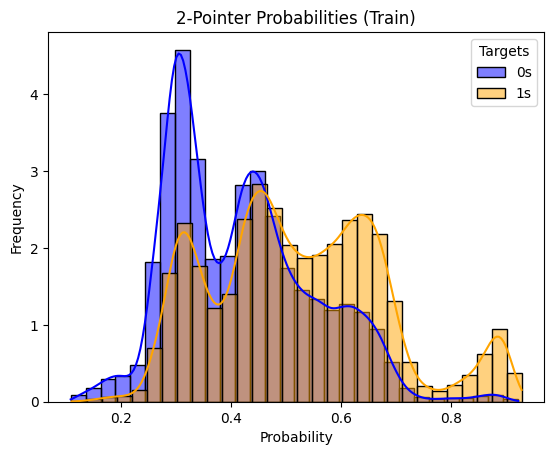

In [17]:
def plot_probabilities_class(probs_0, probs_1, title):
    sns.histplot(probs_0, kde=True, color='blue', bins=30, label='0s', stat='density')
    sns.histplot(probs_1, kde=True, color='orange', bins=30, label='1s', stat='density')

    plt.title(title)
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.legend(title='Targets')
    plt.show()

y_train_pred_0_2p = y_train_pred_2p[y_train_2p == 0]
y_train_pred_1_2p = y_train_pred_2p[y_train_2p == 1]

# y_train_pred_0_3p = y_train_pred_3p[y_train_3p == 0]
# y_train_pred_1_3p = y_train_pred_3p[y_train_3p == 1]

plot_probabilities_class(y_train_pred_0_2p, y_train_pred_1_2p, '2-Pointer Probabilities (Train)')
# plot_probabilities_class(y_train_pred_0_3p, y_train_pred_1_3p, '3-Pointer Probabilities (Train)')

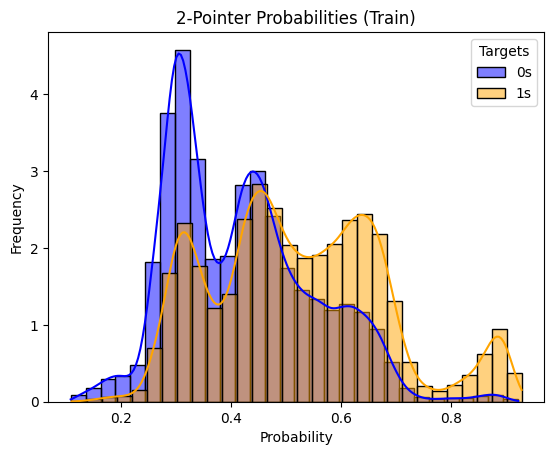

In [18]:
y_train_pred_0_2p = y_train_pred_2p[y_train_2p == 0]
y_train_pred_1_2p = y_train_pred_2p[y_train_2p == 1]

# y_train_pred_0_3p = y_train_pred_3p[y_train_3p == 0]
# y_train_pred_1_3p = y_train_pred_3p[y_train_3p == 1]

plot_probabilities_class(y_train_pred_0_2p, y_train_pred_1_2p, '2-Pointer Probabilities (Train)')

# Recommendation Code

In [19]:
def get_transformed_X_y(sub_merged_df_with_2P,X,y):
    return X.iloc[sub_merged_df_with_2P.index],y.iloc[sub_merged_df_with_2P.index]

In [20]:
merged_df_with_2P.date

0         2022-11-07
1         2022-11-07
2         2022-11-07
3         2022-11-07
4         2022-11-07
             ...    
406461    2023-03-01
406462    2023-03-01
406463    2023-03-01
406464    2023-03-01
406465    2023-03-01
Name: date, Length: 406466, dtype: object

In [21]:
merged_df_with_2P.date = dr.get_correct_game_date(merged_df_with_2P,"date",pad=False,format="%Y-%m-%d")

In [22]:
all_y_pred = bst.predict(X_final, num_iteration=bst.best_iteration)

In [23]:
merged_df_with_2P["predict_prob"] = all_y_pred

In [24]:
def get_team_last_games(merged_df_with_2P,team_id,max_n):
    try: 
        master = merged_df_with_2P.loc[merged_df_with_2P.team_id==team_id].sort_values(by="date",ascending=False)
        all_games = master[["game_id","date"]].drop_duplicates().reset_index(drop=True)
        print(f"Found following games:")
        print(all_games)
        if all_games.shape[0]>max_n:
            rel_games = all_games.iloc[0:max_n]["game_id"]
            master = master.loc[master.game_id.isin(rel_games)]
        return master
        
    except:
        raise("Error while subsetting data")
    

In [25]:
team_shots = get_team_last_games(merged_df_with_2P,"5e875e684dc25ebee5af6797",5)

Found following games:
                     game_id       date
0   636a5fc5531336e79c342993 2022-11-07
1   636c3cffaf77c98d5eb1ed2c 2022-11-08
2   637112e481b591dcab77481a 2022-11-12
3   63730f686c21c0a3cfa222b3 2022-11-14
4   63770e6fda15525fe8562cad 2022-11-17
5   638297e6fd72bcf524c98290 2022-11-26
6   6386da82bfcce0b59e70323c 2022-11-29
7   638eddf80ac0ae9de2163683 2022-12-05
8   6395f11d8e5a1255938bc4e3 2022-12-10
9   639aadb288bfc3a081b491a8 2022-12-14
10  639fef1e65723a0bedea5855 2022-12-18
11  63a2a37e201341bfdb846012 2022-12-20
12  63ad3099d8f2ca2426b11fed 2022-12-28
13  63b137e6316ee5adbd9f6f80 2022-12-31
14  63b7ccb3c4d90d8d95b0df6a 2023-01-05
15  63bb9ef892552d3353bb302b 2023-01-08
16  63bf9b21fe53954f593ce2ec 2023-01-11
17  63c46dd3bb137005bc1136bb 2023-01-14
18  63ca1a4ceb8bdbdbf473175e 2023-01-19
19  63d21f1a9194ab8a1766f777 2023-01-25
20  63d5ec479c4bafffa3b0a934 2023-01-28
21  63db15e1bb7190748002484c 2023-02-01
22  63df0e403141964c0410dea1 2023-02-04
23  63ea3477bdc94

In [26]:
player_level_shots = {}
for player_id in team_shots.player_id.unique():
    player_shots = team_shots.loc[team_shots.player_id==player_id]
    sub_x,sub_y= get_transformed_X_y(player_shots,X_final,y)
    player_level_shots[player_id] = player_shots,sub_x,sub_y

In [27]:
X_final.columns

Index(['Distance', 'Dunk', 'Jumpshot', 'Red_Zone', 'Off_Steal', 'height',
       'Drive', 'opp_team_wl_ratio_prev_season', 'Last_season_Shot_type_perc%',
       'TOT_Zone_made', 'TOT_Shot_type_perc%', 'Layup', 'TOT_2P%',
       'Last_season_Shot_type_attempted', 'score_pre_shot', 'Angle',
       'x_coordinate', 'Big', 'TOT_Shot_type_made', 'Time_Seconds',
       'Shot_type', 'Zone', 'Location'],
      dtype='object')

In [28]:
features_to_explore = ['Jumpshot','Zone','Shot type','Layup']

In [29]:
print("Overall Statistics of all players")
overall_stats = {}
for i in features_to_explore:
    print(f"\n\n\n Distribution and Average Probability of {i} across all shots of players")
    shot_volume = merged_df_with_2P.groupby(i,as_index=False)["shot_id"].size().rename(columns={"size":"num_shots"})
    shot_prob = merged_df_with_2P.groupby(i,as_index=False)["predict_prob"].mean()
    shot_chars = shot_volume.merge(shot_prob,on=i)
    overall_stats[i] = shot_chars
    print(shot_chars)

Overall Statistics of all players



 Distribution and Average Probability of Jumpshot across all shots of players
   Jumpshot  num_shots  predict_prob
0     False     303728      0.520663
1      True     102738      0.306871



 Distribution and Average Probability of Zone across all shots of players
   Zone  num_shots  predict_prob
0     1     199382      0.566856
1   2-1      20289      0.363378
2   2-2      67470      0.399393
3   2-3      16774      0.349570
4   3-1      12856      0.342379
5   3-2      29656      0.366448
6   3-3      11557      0.331408
7   4-1       8859      0.348503
8   4-2      31424      0.362539
9   4-3       8199      0.351768



 Distribution and Average Probability of Shot type across all shots of players
    Shot type  num_shots  predict_prob
0        Dunk      17039      0.831507
1     Floater      15712      0.452049
2   Hook Shot      14805      0.476243
3    Jumpshot     102738      0.306871
4       Layup     212801      0.515905
5       Other     

In [30]:
for k,v in player_level_shots.items():
    feature_stats = {}
    for i in features_to_explore:
        
        player_shot_volume = v[0].groupby(i,as_index=False)["shot_id"].size().rename(columns={"size":"player_num_shots"})
        player_shot_prob = v[0].groupby(i,as_index=False)["predict_prob"].mean().rename(columns={"predict_prob":"player_predict_prob"})
        player_shot_chars = player_shot_volume.merge(player_shot_prob,on=i)
        comparison= player_shot_chars.merge(overall_stats[i],on=i)
        feature_stats[i] = comparison
    player_level_shots[k] = [v[0],v[1],v[2],feature_stats]


In [31]:
with open('file.txt', 'w') as f:
    for k,v in player_level_shots.items():
        f.write("-"*90)
        f.write(f"\n\n\n Statistics of player_id {k} :\n\n")
        for i in features_to_explore:
            f.write("-"*30)
            f.write(f"\n For Feature {i} :\n")
            f.write(player_level_shots[k][3][i].to_string())
            f.write("\n")

# Older Code below

In [220]:
categorical_features = [66]
categorical_names = {}
for feature in categorical_features:
    column = X.iloc[:,feature].values
    le = LabelEncoder()
    le.fit(column)
    X.iloc[:, feature] = le.transform(column)
    categorical_names[feature] = le.classes_

In [88]:
X.shape,y.shape

((406466, 124), (406466,))

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [90]:
X_train.head()

,Distance,Angle,Zone,x_coordinate,y_coordinate,Period,Time_Seconds,Jumpshot,Red_Zone,Floater,Second_Chance,Layup,Paint,Drive,ATO,Off_Turnover,Off_Steal,Hook_Shot,Fastbreak,Pullup,Turnaround,Dunk,Step_Back,Location,w_l_ratio_last_10,opp_w_l_ratio_last_10,w_l_ratio_last_5,opp_w_l_ratio_last_5,w_l_ratio_last_3,opp_w_l_ratio_last_3,w_l_ratio_last_1,opp_w_l_ratio_last_1,score_pre_shot,score_pre_shot_diff,clutch_time,num_blockers_on_team,last_1_game_usage_ratio,last_3_game_usage_ratio,last_5_game_usage_ratio,last_10_game_usage_ratio,current_season_usage_ratio,past_season_usage_ratio,Big,Mid,Small,height,LBA_position,year,team_wl_ratio_prev_season,opp_team_wl_ratio_prev_season,D1,L1_Zone_made,L1_Zone_attempted,L1_Zone_perc%,L3_Zone_made,L3_Zone_attempted,L3_Zone_perc%,L5_Zone_made,L5_Zone_attempted,L5_Zone_perc%,L10_Zone_made,L10_Zone_attempted,L10_Zone_perc%,TOT_Zone_made,TOT_Zone_attempted,TOT_Zone_perc%,Shot_type,L1_Shot_type_made,L1_Shot_type_attempted,L1_Shot_type_perc%,L3_Shot_type_made,L3_Shot_type_attempted,L3_Shot_type_perc%,L5_Shot_type_made,L5_Shot_type_attempted,L5_Shot_type_perc%,L10_Shot_type_made,L10_Shot_type_attempted,L10_Shot_type_perc%,TOT_Shot_type_made,TOT_Shot_type_attempted,TOT_Shot_type_perc%,Last_season_Shot_type_made,Last_season_Shot_type_attempted,Last_season_Shot_type_perc%,Last_season_Zone_made,Last_season_Zone_attempted,Last_season_Zone_perc%,L1_played,L1_2PM,L1_2PA,L1_2P%,L1_Jumpshots_assisted_on,L1_Jumpshots_assisted%,L3_played,L3_2PM,L3_2PA,L3_2P%,L3_Jumpshots_assisted_on,L3_Jumpshots_assisted%,L5_played,L5_2PM,L5_2PA,L5_2P%,L5_Jumpshots_assisted_on,L5_Jumpshots_assisted%,L10_played,L10_2PM,L10_2PA,L10_2P%,L10_Jumpshots_assisted_on,L10_Jumpshots_assisted%,TOT_played,TOT_2PM,TOT_2PA,TOT_2P%,TOT_Jumpshots_assisted_on,TOT_Jumpshots_assisted%,Last_season_played,Last_season_2PM,Last_season_2PA,Last_season_2P%,Last_season_Jumpshots_assisted_on,Last_season_Jumpshots_assisted%
266877,6.05,94.7,2-2,25.5,11.3,1,786,False,False,False,False,True,True,False,False,True,False,False,False,False,False,False,False,Away,0.700000,0.500000,0.6,0.4,0.666667,0.333333,1.0,0.0,11,0,0,0,0.250000,0.293103,0.304918,NaN,0.304918,0.229386,0,4,1,73.0,Small,So,0.428571,0.500000,True,0.0,0.0,NaN,0.000000,0.000000,NaN,0.0,0.0,NaN,0.1,0.2,0.500000,0.045455,0.136364,0.333333,Layup,0.0,2.0,0.000000,0.333333,1.666667,0.2,0.8,2.4,0.333333,1.1,2.0,0.550000,1.00000,1.727273,0.578947,0.961538,2.730769,0.352113,0.230769,0.769231,0.300000,1.0,0.0,2.0,0.000000,0.0,NaN,3.0,0.666667,2.000000,0.333333,0.0,0.000000,5.0,1.0,2.8,0.357143,0.0,0.000000,10.0,1.3,2.7,0.481481,0.0,0.000000,22.0,1.318182,2.454545,0.537037,0.0,0.000000,26.0,1.384615,3.807692,0.363636,0.0,0.000000
140553,5.47,111.5,2-2,27.0,10.3,1,66,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,Away,0.444444,0.666667,0.4,0.8,0.333333,1.000000,0.0,1.0,30,-12,0,0,0.241379,0.233645,0.236651,0.248773,0.273509,0.263815,0,2,2,74.0,Small,So,0.678571,0.571429,True,1.0,1.0,1.0,0.666667,0.666667,1.000000,0.4,0.6,0.666667,0.5,1.2,0.416667,0.500000,1.200000,0.416667,Layup,2.0,3.0,0.666667,1.333333,2.666667,0.5,1.2,2.2,0.545455,1.3,2.3,0.565217,1.30000,2.300000,0.565217,0.294118,0.647059,0.454545,0.000000,0.117647,0.000000,1.0,4.0,5.0,0.800000,0.0,0.0,3.0,2.666667,5.000000,0.533333,0.0,0.000000,5.0,2.0,3.6,0.555556,0.0,0.000000,10.0,1.8,4.2,0.428571,0.0,0.000000,10.0,1.800000,4.200000,0.428571,0.0,0.000000,17.0,0.352941,0.823529,0.428571,0.0,0.000000
146853,0.39,90.0,1,25.0,5.6,2,22,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,Away,0.444444,0.555556,0.4,0.4,0.333333,0.333333,0.0,0.0,67,-23,0,0,0.200000,0.202454,0.197333,0.208130,0.207143,0.281116,1,4,0,77.0,Mid,Jr,0.217391,0.222222,True,1.0,2.0,0.5,0.333333,1.333333,0.250000,0.2,1.2,0.166667,0.3,1.0,0.300000,0.300000,1.000000,0.300000,Layup,0.0,0.0,NaN,0.000000,1.000000,0.0,0.0,0.8,0.000000,0.4,1.2,0.333333,0.40000,1.200000,0.333333,0.809524,1.952381,0.414634,0

In [91]:
def get_transformed_X_y(sub_merged_df_with_2P,X,y):
    return X.iloc[sub_merged_df_with_2P.index],y.iloc[sub_merged_df_with_2P.index]

In [92]:
# Create a LightGBM dataset and specify the categorical features
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categorical_features)

# Set up LightGBM parameters
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the model
num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

# Make predictions
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

[LightGBM] [Info] Number of positive: 151756, number of negative: 173416
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13912
[LightGBM] [Info] Number of data points in the train set: 325172, number of used features: 123
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.466695 -> initscore=-0.133419
[LightGBM] [Info] Start training from score -0.133419


In [93]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

def find_best_threshold(y_true, y_pred_probs):
    thresholds = [i/100 for i in range(100)]  # This gives [0, 0.01, 0.02,...,0.99]
    best_threshold = 0
    best_f1 = 0
    
    for threshold in thresholds:
        y_pred_binary = [1 if x >= threshold else 0 for x in y_pred_probs]
        current_f1 = f1_score(y_true, y_pred_binary)
        
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_threshold = threshold
            
    return best_threshold

# Find the best threshold on the training data
y_train_pred = bst.predict(X_train, num_iteration=bst.best_iteration)
best_threshold = find_best_threshold(y_test, y_pred)

# Now, apply the best threshold to get binary predictions
y_train_pred_binary = [1 if x >= best_threshold else 0 for x in y_train_pred]
y_pred_binary = [1 if x >= best_threshold else 0 for x in y_pred]

# Performance Metrics for Train data
train_accuracy = accuracy_score(y_train, y_train_pred_binary)
train_precision = precision_score(y_train, y_train_pred_binary)
train_recall = recall_score(y_train, y_train_pred_binary)
train_f1 = f1_score(y_train, y_train_pred_binary)
train_auc_roc = roc_auc_score(y_train, y_train_pred)

print('Train-------------------------------')
print(f"Train Accuracy: {train_accuracy}")
print(f"Train Precision: {train_precision}")
print(f"Train Recall: {train_recall}")
print(f"Train F1 Score: {train_f1}")
print(f"Train AUC ROC: {train_auc_roc}")

# Performance Metrics for Test data
test_accuracy = accuracy_score(y_test, y_pred_binary)
test_precision = precision_score(y_test, y_pred_binary)
test_recall = recall_score(y_test, y_pred_binary)
test_f1 = f1_score(y_test, y_pred_binary)
test_auc_roc = roc_auc_score(y_test, y_pred)

print('Test-------------------------------')
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1}")
print(f"Test AUC ROC: {test_auc_roc}")

# Displaying the best threshold
print(f"Optimum Threshold for Maximum F1 Score: {best_threshold}")


Train-------------------------------
Train Accuracy: 0.5760397574206881
Train Precision: 0.5279464881866961
Train Recall: 0.8649213210680302
Train F1 Score: 0.6556719467298078
Train AUC ROC: 0.6886688588086283
Test-------------------------------
Test Accuracy: 0.5733633478485497
Test Precision: 0.52587164828086
Test Recall: 0.8616740553092674
Test F1 Score: 0.6531387824904241
Test AUC ROC: 0.6828413334057735
Optimum Threshold for Maximum F1 Score: 0.33


Text(0.5, 1.0, 'Feature Importance')

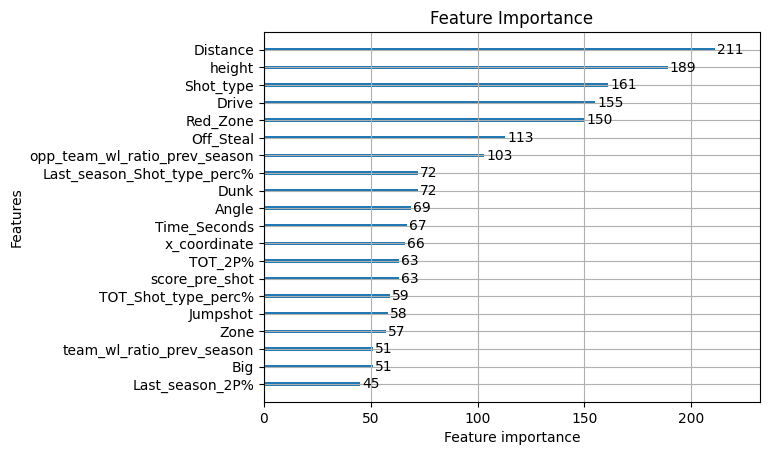

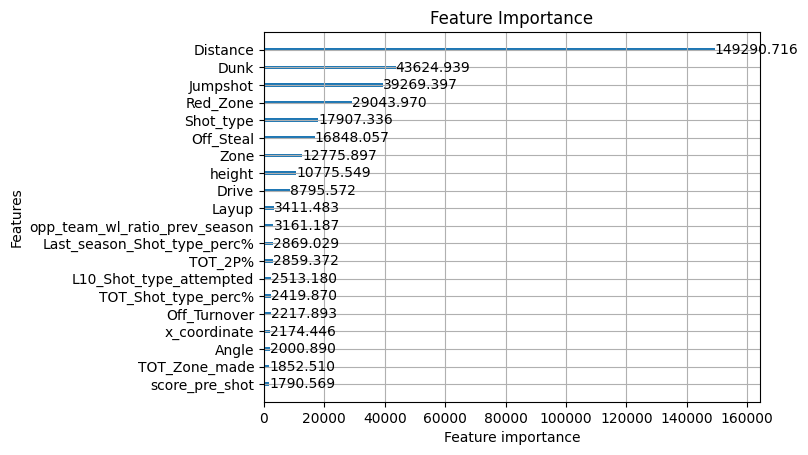

In [12]:
lgb.plot_importance(bst, importance_type='split', max_num_features=20)
plt.title("Feature Importance")
lgb.plot_importance(bst, importance_type='gain', max_num_features=20)
plt.title("Feature Importance")

In [94]:
# Function to plot probabilities
def plot_probabilities(probs, title):
    sns.histplot(probs, kde=True, bins=30)
    plt.title(title)
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def calculate_combined_probabilities(prob_2p, prob_3p):
    weighted_2p = prob_2p * 2
    weighted_3p = prob_3p * 3
    return np.concatenate([weighted_2p, weighted_3p])

In [95]:
y_train_pred_2p = y_train_pred
best_threshold_2p = best_threshold
y_pred_2p = y_pred
y_train_2p = y_train
y_test_2p = y_test
X_2p = X

In [96]:
# Displaying the best thresholds
print(f"Best threshold for 2-pointers: {best_threshold_2p}")
# print(f"Best threshold for 3-pointers: {best_threshold_3p}")

# Apply the best threshold to get binary predictions
y_train_pred_2p_binary = [1 if x >= best_threshold_2p else 0 for x in y_train_pred_2p]
# y_train_pred_3p_binary = [1 if x >= best_threshold_3p else 0 for x in y_train_pred_3p]
y_pred_2p_binary = [1 if x >= best_threshold_2p else 0 for x in y_pred_2p]
# y_pred_3p_binary = [1 if x >= best_threshold_3p else 0 for x in y_pred_3p]

Best threshold for 2-pointers: 0.33


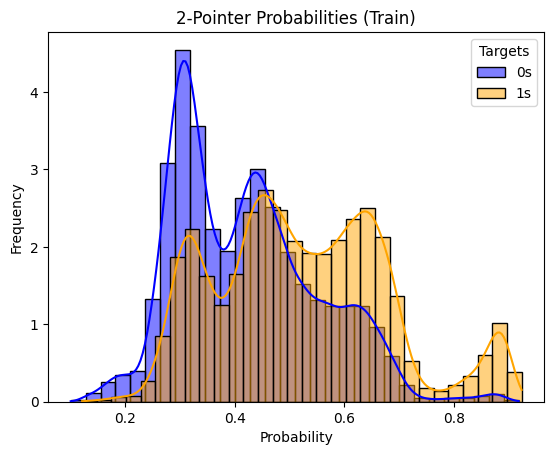

In [97]:
def plot_probabilities_class(probs_0, probs_1, title):
    sns.histplot(probs_0, kde=True, color='blue', bins=30, label='0s', stat='density')
    sns.histplot(probs_1, kde=True, color='orange', bins=30, label='1s', stat='density')

    plt.title(title)
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.legend(title='Targets')
    plt.show()

y_train_pred_0_2p = y_train_pred_2p[y_train_2p == 0]
y_train_pred_1_2p = y_train_pred_2p[y_train_2p == 1]

# y_train_pred_0_3p = y_train_pred_3p[y_train_3p == 0]
# y_train_pred_1_3p = y_train_pred_3p[y_train_3p == 1]

plot_probabilities_class(y_train_pred_0_2p, y_train_pred_1_2p, '2-Pointer Probabilities (Train)')
# plot_probabilities_class(y_train_pred_0_3p, y_train_pred_1_3p, '3-Pointer Probabilities (Train)')

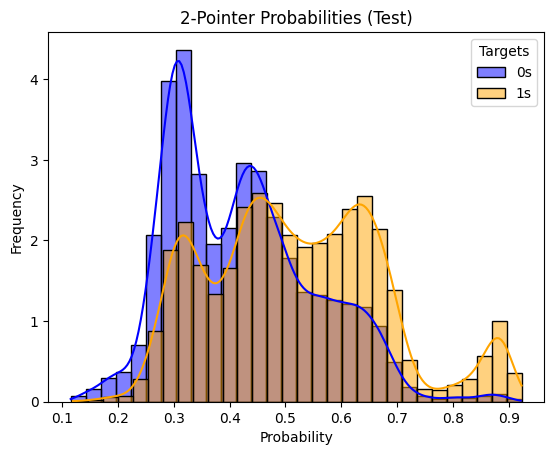

In [98]:
y_test_pred_2p = np.array(y_pred_2p)
# y_test_pred_3p = np.array(y_pred_3p)
y_test_2p = np.array(y_test_2p)
# y_test_3p = np.array(y_test_3p)

y_test_2p = y_test_2p.reshape(-1)
# y_test_3p = y_test_3p.reshape(-1)

y_test_pred_0_2p = y_test_pred_2p[y_test_2p == 0]
y_test_pred_1_2p = y_test_pred_2p[y_test_2p == 1]
# y_test_pred_0_3p = y_test_pred_3p[y_test_3p == 0]
# y_test_pred_1_3p = y_test_pred_3p[y_test_3p == 1]

plot_probabilities_class(y_test_pred_0_2p, y_test_pred_1_2p, '2-Pointer Probabilities (Test)')
# plot_probabilities_class(y_test_pred_0_3p, y_test_pred_1_3p, '3-Pointer Probabilities (Test)')

In [104]:
X_train[y_train_pred_2p>0.85].Zone.value_counts()

Zone
 1      8530
 2-1       0
 2-2       0
 2-3       0
 3-1       0
 3-2       0
 3-3       0
 4-1       0
 4-2       0
 4-3       0
Name: count, dtype: int64

In [107]:
X_train.height.median()

78.0

In [106]:
X_train[y_train_pred_2p>0.85].height.median()

81.0

In [112]:
X_train[y_train_pred_2p>0.85].Dunk.value_counts()

Dunk
True     7955
False     575
Name: count, dtype: int64

In [113]:
y_train[X_train.Dunk==1].mean(),y_train.mean()

(0.8350920602576232, 0.46669454934619214)

In [114]:
X_train[X_train.Dunk==1].Zone.value_counts()

Zone
 1      12663
 2-2      869
 2-3       96
 2-1       91
 3-2       22
 3-1        0
 3-3        0
 4-1        0
 4-2        0
 4-3        0
Name: count, dtype: int64

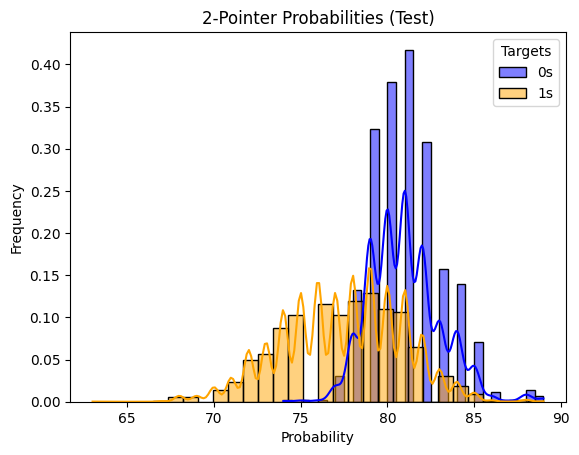

In [108]:
plot_probabilities_class(X_train[y_train_pred_2p>0.85].height, X_train.height, '2-Pointer Probabilities (Test)')

In [72]:
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values[1], X_train, plot_type='dot')

In [25]:
merged_df_with_2P.Zone.unique()

array([' 4-2', ' 3-1', ' 3-2', ' 2-2', ' 1', ' 4-3', ' 4-1', ' 2-1',
       ' 3-3', ' 2-3'], dtype=object)

In [26]:
merged_df_with_2P.Zone.unique()

array([' 4-2', ' 3-1', ' 3-2', ' 2-2', ' 1', ' 4-3', ' 4-1', ' 2-1',
       ' 3-3', ' 2-3'], dtype=object)

In [74]:
X_game_1,y_game_1 = get_transformed_X_y(merged_df_with_2P[merged_df_with_2P.Zone.isin([' 1',' 2-2'])],X,y)

In [75]:
X_game_1.shape

(294504, 124)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


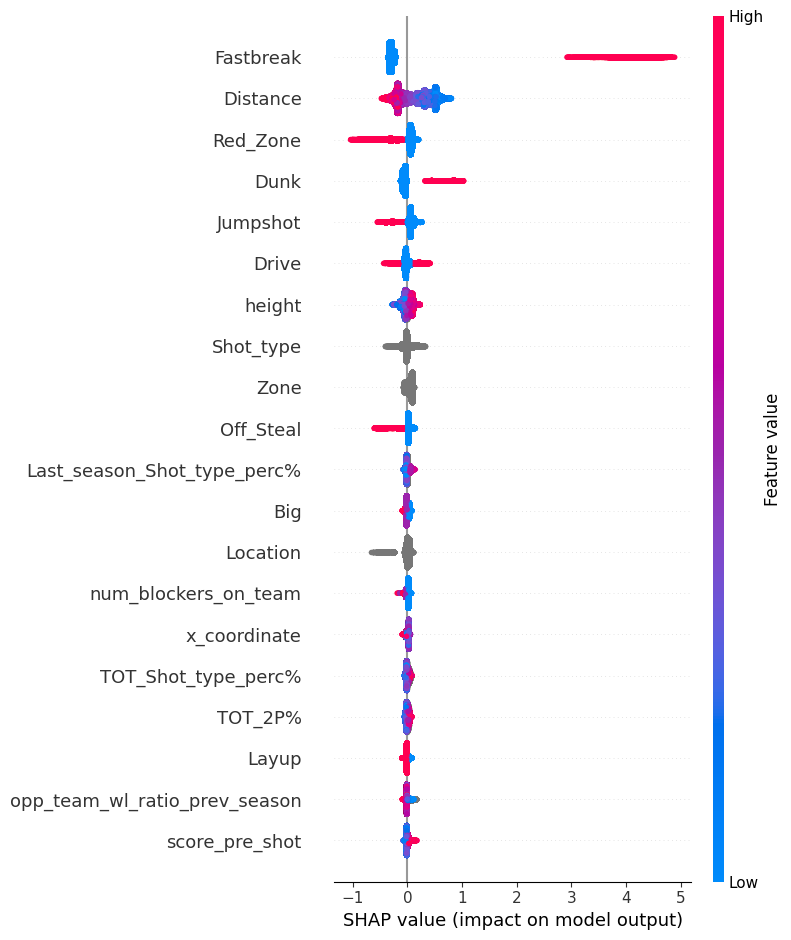

In [76]:
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_game_1)
shap.summary_plot(shap_values[1], X_game_1, plot_type='dot')

In [116]:
[i for i in X_train.columns]

['Distance',
 'Angle',
 'Zone',
 'x_coordinate',
 'y_coordinate',
 'Period',
 'Time_Seconds',
 'Jumpshot',
 'Red_Zone',
 'Floater',
 'Second_Chance',
 'Layup',
 'Paint',
 'Drive',
 'ATO',
 'Off_Turnover',
 'Off_Steal',
 'Hook_Shot',
 'Fastbreak',
 'Pullup',
 'Turnaround',
 'Dunk',
 'Step_Back',
 'Location',
 'w_l_ratio_last_10',
 'opp_w_l_ratio_last_10',
 'w_l_ratio_last_5',
 'opp_w_l_ratio_last_5',
 'w_l_ratio_last_3',
 'opp_w_l_ratio_last_3',
 'w_l_ratio_last_1',
 'opp_w_l_ratio_last_1',
 'score_pre_shot',
 'score_pre_shot_diff',
 'clutch_time',
 'num_blockers_on_team',
 'last_1_game_usage_ratio',
 'last_3_game_usage_ratio',
 'last_5_game_usage_ratio',
 'last_10_game_usage_ratio',
 'current_season_usage_ratio',
 'past_season_usage_ratio',
 'Big',
 'Mid',
 'Small',
 'height',
 'LBA_position',
 'year',
 'team_wl_ratio_prev_season',
 'opp_team_wl_ratio_prev_season',
 'D1',
 'L1_Zone_made',
 'L1_Zone_attempted',
 'L1_Zone_perc%',
 'L3_Zone_made',
 'L3_Zone_attempted',
 'L3_Zone_perc%',
 

In [235]:
import lime

In [236]:
X_train

,Fastbreak,Distance,Jumpshot,Dunk,Red_Zone,Shot_type,Off_Steal,height,Drive,TOT_Zone_made,opp_team_wl_ratio_prev_season
156928,False,0.39,False,False,False,4,False,76.0,False,0.900000,0.387097
433537,False,7.25,False,False,False,4,False,72.0,True,0.750000,0.733333
345745,False,5.91,False,False,False,4,False,73.0,False,0.000000,0.117647
248940,False,5.17,False,False,False,4,False,77.0,False,0.166667,0.260870
58834,False,2.48,False,False,False,4,False,85.0,False,1.000000,0.200000
...,...,...,...,...,...,...,...,...,...,...,...
259178,False,2.32,False,False,False,4,False,78.0,True,0.210526,0.230769
365838,False,5.19,False,False,False,4,False,81.0,False,0.400000,0.565217
131932,False,10.69,False,False,False,2,False,82.0,False,0.000000,0.666667
146867,False,6.89,False,False,False,4,False,79.0,False,0.000000,NaN


In [237]:
#merged_df_with_2P.iloc[156928:156929]
X_1,y_1 = X.iloc[156928][features_list],y.iloc[156928]


In [117]:
y_pred = pd.concat(y_pred_2p,y_pred_

(325172, 124)

In [238]:
merged_df_with_2P.iloc[156928]['Made']

True

In [249]:
import lime.lime_tabular
feature_names = X_train.columns.to_list()
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values ,mode="classification",feature_names = feature_names,
                                                   categorical_features=[5], 
                                                   categorical_names=['Shot_type'],kernel_width=None,discretize_continuous=False)


In [259]:
np.array([[i,j] for i, j in zip((1-bst.predict(X_train)),bst.predict(X_train))])

array([[0.35674161, 0.64325839],
       [0.50974595, 0.49025405],
       [0.63948082, 0.36051918],
       ...,
       [0.58727407, 0.41272593],
       [0.5703183 , 0.4296817 ],
       [0.5571572 , 0.4428428 ]])

In [260]:
predict_fn = lambda x: np.array([[i,j] for i, j in zip((1-bst.predict(x,num_iteration=bst.best_iteration)),bst.predict(X_train,num_iteration=bst.best_iteration))]).astype(float)


In [262]:
exp = explainer.explain_instance(X_1, predict_fn,num_features=5,top_labels=5)
exp.show_in_notebook(show_all=False)


Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
